# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [2]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [7]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [8]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [61]:
client = MongoClient(mongod_connect)
db = client.lab11 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [27]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [15]:
track = ['covid19'] # define the keywords, tweets contain election

locations = [39.081280, -105.529292] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [26]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [39]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [49]:
count = 100 #number of returned tweets, default and max is 100
geocode = "39.081280,-105.529292,300mi"  # defin the location, in Harrisonburg, VA
q = "covid"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [50]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Dec 02 20:18:55 +0000 2021'
'Thu Dec 02 20:18:38 +0000 2021'
'Thu Dec 02 20:18:23 +0000 2021'
'Thu Dec 02 20:16:24 +0000 2021'
'Thu Dec 02 20:16:04 +0000 2021'
'Thu Dec 02 20:16:01 +0000 2021'
'Thu Dec 02 20:15:42 +0000 2021'
'Thu Dec 02 20:15:35 +0000 2021'
'Thu Dec 02 20:15:00 +0000 2021'
'Thu Dec 02 20:14:31 +0000 2021'
'Thu Dec 02 20:13:51 +0000 2021'
'Thu Dec 02 20:11:43 +0000 2021'
'Thu Dec 02 20:09:58 +0000 2021'
'Thu Dec 02 20:09:30 +0000 2021'
'Thu Dec 02 20:08:54 +0000 2021'
'Thu Dec 02 20:07:27 +0000 2021'
'Thu Dec 02 20:05:02 +0000 2021'
'Thu Dec 02 20:02:39 +0000 2021'
'Thu Dec 02 20:02:22 +0000 2021'
'Thu Dec 02 20:01:44 +0000 2021'
'Thu Dec 02 20:00:37 +0000 2021'
'Thu Dec 02 19:57:59 +0000 2021'
'Thu Dec 02 19:57:34 +0000 2021'
'Thu Dec 02 19:57:33 +0000 2021'
'Thu Dec 02 19:56:29 +0000 2021'
'Thu Dec 02 19:56:28 +0000 2021'
'Thu Dec 02 19:55:48 +0000 2021'
'Thu Dec 02 19:55:42 +0000 2021'
'Thu Dec 02 19:55:20 +0000 2021'
'Thu Dec 02 19:53:28 +0000 2021'
'Thu Dec 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [51]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Dec 02 19:00:33 +0000 2021'
'Thu Dec 02 18:58:34 +0000 2021'
'Thu Dec 02 18:58:33 +0000 2021'
'Thu Dec 02 18:58:09 +0000 2021'
'Thu Dec 02 18:57:24 +0000 2021'
'Thu Dec 02 18:56:08 +0000 2021'
'Thu Dec 02 18:55:50 +0000 2021'
'Thu Dec 02 18:55:38 +0000 2021'
'Thu Dec 02 18:55:30 +0000 2021'
'Thu Dec 02 18:55:28 +0000 2021'
'Thu Dec 02 18:54:09 +0000 2021'
'Thu Dec 02 18:53:51 +0000 2021'
'Thu Dec 02 18:53:05 +0000 2021'
'Thu Dec 02 18:52:58 +0000 2021'
'Thu Dec 02 18:52:37 +0000 2021'
'Thu Dec 02 18:52:15 +0000 2021'
'Thu Dec 02 18:52:14 +0000 2021'
'Thu Dec 02 18:52:11 +0000 2021'
'Thu Dec 02 18:52:04 +0000 2021'
'Thu Dec 02 18:51:45 +0000 2021'
'Thu Dec 02 18:51:35 +0000 2021'
'Thu Dec 02 18:51:06 +0000 2021'
'Thu Dec 02 18:50:59 +0000 2021'
'Thu Dec 02 18:50:53 +0000 2021'
'Thu Dec 02 18:50:50 +0000 2021'
'Thu Dec 02 18:49:47 +0000 2021'
'Thu Dec 02 18:49:21 +0000 2021'
'Thu Dec 02 18:47:41 +0000 2021'
'Thu Dec 02 18:47:15 +0000 2021'
'Thu Dec 02 18:46:37 +0000 2021'
'Thu Dec 0

'Thu Dec 02 15:32:59 +0000 2021'
'Thu Dec 02 15:31:08 +0000 2021'
'Thu Dec 02 15:30:53 +0000 2021'
'Thu Dec 02 15:30:47 +0000 2021'
'Thu Dec 02 15:30:35 +0000 2021'
'Thu Dec 02 15:30:13 +0000 2021'
'Thu Dec 02 15:30:01 +0000 2021'
'Thu Dec 02 15:28:35 +0000 2021'
'Thu Dec 02 15:27:07 +0000 2021'
'Thu Dec 02 15:21:58 +0000 2021'
'Thu Dec 02 15:21:23 +0000 2021'
'Thu Dec 02 15:20:46 +0000 2021'
'Thu Dec 02 15:18:10 +0000 2021'
'Thu Dec 02 15:17:02 +0000 2021'
'Thu Dec 02 15:16:22 +0000 2021'
'Thu Dec 02 15:15:07 +0000 2021'
'Thu Dec 02 15:14:46 +0000 2021'
'Thu Dec 02 15:13:21 +0000 2021'
'Thu Dec 02 15:10:43 +0000 2021'
'Thu Dec 02 15:10:29 +0000 2021'
'Thu Dec 02 15:09:34 +0000 2021'
'Thu Dec 02 15:08:48 +0000 2021'
'Thu Dec 02 15:07:28 +0000 2021'
'Thu Dec 02 15:05:05 +0000 2021'
'Thu Dec 02 15:04:24 +0000 2021'
'Thu Dec 02 15:03:50 +0000 2021'
'Thu Dec 02 15:02:53 +0000 2021'
'Thu Dec 02 15:02:42 +0000 2021'
'Thu Dec 02 15:02:37 +0000 2021'
'Thu Dec 02 15:02:11 +0000 2021'
'Thu Dec 0

'Thu Dec 02 04:26:05 +0000 2021'
'Thu Dec 02 04:25:42 +0000 2021'
'Thu Dec 02 04:22:00 +0000 2021'
'Thu Dec 02 04:16:25 +0000 2021'
'Thu Dec 02 04:14:19 +0000 2021'
'Thu Dec 02 04:13:45 +0000 2021'
'Thu Dec 02 04:13:33 +0000 2021'
'Thu Dec 02 04:10:25 +0000 2021'
'Thu Dec 02 04:09:50 +0000 2021'
'Thu Dec 02 04:09:32 +0000 2021'
'Thu Dec 02 04:08:33 +0000 2021'
'Thu Dec 02 04:04:47 +0000 2021'
'Thu Dec 02 04:03:52 +0000 2021'
'Thu Dec 02 04:03:29 +0000 2021'
'Thu Dec 02 04:03:28 +0000 2021'
'Thu Dec 02 04:00:15 +0000 2021'
'Thu Dec 02 04:00:14 +0000 2021'
'Thu Dec 02 03:59:48 +0000 2021'
'Thu Dec 02 03:58:26 +0000 2021'
'Thu Dec 02 03:57:46 +0000 2021'
'Thu Dec 02 03:57:46 +0000 2021'
'Thu Dec 02 03:57:37 +0000 2021'
'Thu Dec 02 03:57:35 +0000 2021'
'Thu Dec 02 03:57:19 +0000 2021'
'Thu Dec 02 03:56:51 +0000 2021'
'Thu Dec 02 03:55:32 +0000 2021'
'Thu Dec 02 03:54:36 +0000 2021'
'Thu Dec 02 03:54:20 +0000 2021'
'Thu Dec 02 03:53:49 +0000 2021'
'Thu Dec 02 03:49:16 +0000 2021'
'Thu Dec 0

'Wed Dec 01 23:31:03 +0000 2021'
'Wed Dec 01 23:30:53 +0000 2021'
'Wed Dec 01 23:28:21 +0000 2021'
'Wed Dec 01 23:26:41 +0000 2021'
'Wed Dec 01 23:26:05 +0000 2021'
'Wed Dec 01 23:24:49 +0000 2021'
'Wed Dec 01 23:22:00 +0000 2021'
'Wed Dec 01 23:21:06 +0000 2021'
'Wed Dec 01 23:20:04 +0000 2021'
'Wed Dec 01 23:19:55 +0000 2021'
'Wed Dec 01 23:18:54 +0000 2021'
'Wed Dec 01 23:17:27 +0000 2021'
'Wed Dec 01 23:16:56 +0000 2021'
'Wed Dec 01 23:16:01 +0000 2021'
'Wed Dec 01 23:14:24 +0000 2021'
'Wed Dec 01 23:13:08 +0000 2021'
'Wed Dec 01 23:12:39 +0000 2021'
'Wed Dec 01 23:12:37 +0000 2021'
'Wed Dec 01 23:12:22 +0000 2021'
'Wed Dec 01 23:09:25 +0000 2021'
'Wed Dec 01 23:08:53 +0000 2021'
'Wed Dec 01 23:08:26 +0000 2021'
'Wed Dec 01 23:08:04 +0000 2021'
'Wed Dec 01 23:07:21 +0000 2021'
'Wed Dec 01 23:07:10 +0000 2021'
'Wed Dec 01 23:05:29 +0000 2021'
'Wed Dec 01 23:01:51 +0000 2021'
'Wed Dec 01 23:01:43 +0000 2021'
'Wed Dec 01 23:00:07 +0000 2021'
'Wed Dec 01 22:58:38 +0000 2021'
'Wed Dec 0

'Wed Dec 01 19:20:18 +0000 2021'
'Wed Dec 01 19:19:58 +0000 2021'
'Wed Dec 01 19:19:21 +0000 2021'
'Wed Dec 01 19:18:27 +0000 2021'
'Wed Dec 01 19:17:03 +0000 2021'
'Wed Dec 01 19:16:34 +0000 2021'
'Wed Dec 01 19:15:03 +0000 2021'
'Wed Dec 01 19:15:01 +0000 2021'
'Wed Dec 01 19:13:33 +0000 2021'
'Wed Dec 01 19:11:05 +0000 2021'
'Wed Dec 01 19:10:21 +0000 2021'
'Wed Dec 01 19:10:16 +0000 2021'
'Wed Dec 01 19:09:55 +0000 2021'
'Wed Dec 01 19:09:55 +0000 2021'
'Wed Dec 01 19:08:36 +0000 2021'
'Wed Dec 01 19:07:04 +0000 2021'
'Wed Dec 01 19:06:04 +0000 2021'
'Wed Dec 01 19:05:38 +0000 2021'
'Wed Dec 01 19:05:37 +0000 2021'
'Wed Dec 01 19:04:40 +0000 2021'
'Wed Dec 01 19:02:37 +0000 2021'
'Wed Dec 01 19:01:45 +0000 2021'
'Wed Dec 01 19:01:27 +0000 2021'
'Wed Dec 01 19:01:07 +0000 2021'
'Wed Dec 01 19:01:05 +0000 2021'
'Wed Dec 01 19:00:39 +0000 2021'
'Wed Dec 01 19:00:21 +0000 2021'
'Wed Dec 01 19:00:12 +0000 2021'
'Wed Dec 01 19:00:02 +0000 2021'
'Wed Dec 01 19:00:01 +0000 2021'
'Wed Dec 0

'Wed Dec 01 15:21:06 +0000 2021'
'Wed Dec 01 15:20:02 +0000 2021'
'Wed Dec 01 15:19:26 +0000 2021'
'Wed Dec 01 15:16:07 +0000 2021'
'Wed Dec 01 15:15:33 +0000 2021'
'Wed Dec 01 15:12:07 +0000 2021'
'Wed Dec 01 15:10:58 +0000 2021'
'Wed Dec 01 15:10:21 +0000 2021'
'Wed Dec 01 15:07:37 +0000 2021'
'Wed Dec 01 15:07:00 +0000 2021'
'Wed Dec 01 15:06:34 +0000 2021'
'Wed Dec 01 15:06:19 +0000 2021'
'Wed Dec 01 15:04:19 +0000 2021'
'Wed Dec 01 15:01:27 +0000 2021'
'Wed Dec 01 15:00:10 +0000 2021'
'Wed Dec 01 14:59:57 +0000 2021'
'Wed Dec 01 14:59:16 +0000 2021'
'Wed Dec 01 14:57:51 +0000 2021'
'Wed Dec 01 14:57:51 +0000 2021'
'Wed Dec 01 14:57:11 +0000 2021'
'Wed Dec 01 14:56:21 +0000 2021'
'Wed Dec 01 14:56:21 +0000 2021'
'Wed Dec 01 14:54:17 +0000 2021'
'Wed Dec 01 14:53:13 +0000 2021'
'Wed Dec 01 14:53:03 +0000 2021'
'Wed Dec 01 14:51:15 +0000 2021'
'Wed Dec 01 14:51:08 +0000 2021'
'Wed Dec 01 14:50:59 +0000 2021'
'Wed Dec 01 14:50:17 +0000 2021'
'Wed Dec 01 14:49:25 +0000 2021'
'Wed Dec 0

'Wed Dec 01 04:44:58 +0000 2021'
'Wed Dec 01 04:44:44 +0000 2021'
'Wed Dec 01 04:41:23 +0000 2021'
'Wed Dec 01 04:39:33 +0000 2021'
'Wed Dec 01 04:38:50 +0000 2021'
'Wed Dec 01 04:37:19 +0000 2021'
'Wed Dec 01 04:37:16 +0000 2021'
'Wed Dec 01 04:36:23 +0000 2021'
'Wed Dec 01 04:36:10 +0000 2021'
'Wed Dec 01 04:35:20 +0000 2021'
'Wed Dec 01 04:32:18 +0000 2021'
'Wed Dec 01 04:31:45 +0000 2021'
'Wed Dec 01 04:29:54 +0000 2021'
'Wed Dec 01 04:29:12 +0000 2021'
'Wed Dec 01 04:27:47 +0000 2021'
'Wed Dec 01 04:27:31 +0000 2021'
'Wed Dec 01 04:26:39 +0000 2021'
'Wed Dec 01 04:25:56 +0000 2021'
'Wed Dec 01 04:25:01 +0000 2021'
'Wed Dec 01 04:21:55 +0000 2021'
'Wed Dec 01 04:20:40 +0000 2021'
'Wed Dec 01 04:18:16 +0000 2021'
'Wed Dec 01 04:17:59 +0000 2021'
'Wed Dec 01 04:17:47 +0000 2021'
'Wed Dec 01 04:17:43 +0000 2021'
'Wed Dec 01 04:16:03 +0000 2021'
'Wed Dec 01 04:15:51 +0000 2021'
'Wed Dec 01 04:15:13 +0000 2021'
'Wed Dec 01 04:14:10 +0000 2021'
'Wed Dec 01 04:13:50 +0000 2021'
'Wed Dec 0

'Tue Nov 30 23:56:38 +0000 2021'
'Tue Nov 30 23:54:41 +0000 2021'
'Tue Nov 30 23:54:06 +0000 2021'
'Tue Nov 30 23:53:21 +0000 2021'
'Tue Nov 30 23:52:12 +0000 2021'
'Tue Nov 30 23:52:05 +0000 2021'
'Tue Nov 30 23:49:23 +0000 2021'
'Tue Nov 30 23:49:23 +0000 2021'
'Tue Nov 30 23:48:26 +0000 2021'
'Tue Nov 30 23:47:52 +0000 2021'
'Tue Nov 30 23:47:11 +0000 2021'
'Tue Nov 30 23:46:33 +0000 2021'
'Tue Nov 30 23:46:11 +0000 2021'
'Tue Nov 30 23:46:00 +0000 2021'
'Tue Nov 30 23:45:38 +0000 2021'
'Tue Nov 30 23:45:17 +0000 2021'
'Tue Nov 30 23:45:10 +0000 2021'
'Tue Nov 30 23:45:05 +0000 2021'
'Tue Nov 30 23:43:30 +0000 2021'
'Tue Nov 30 23:43:29 +0000 2021'
'Tue Nov 30 23:42:44 +0000 2021'
'Tue Nov 30 23:39:24 +0000 2021'
'Tue Nov 30 23:38:37 +0000 2021'
'Tue Nov 30 23:36:56 +0000 2021'
'Tue Nov 30 23:36:37 +0000 2021'
'Tue Nov 30 23:35:53 +0000 2021'
'Tue Nov 30 23:35:20 +0000 2021'
'Tue Nov 30 23:34:33 +0000 2021'
'Tue Nov 30 23:34:11 +0000 2021'
'Tue Nov 30 23:33:14 +0000 2021'
'Tue Nov 3

'Tue Nov 30 19:50:48 +0000 2021'
'Tue Nov 30 19:49:44 +0000 2021'
'Tue Nov 30 19:46:40 +0000 2021'
'Tue Nov 30 19:46:32 +0000 2021'
'Tue Nov 30 19:45:29 +0000 2021'
'Tue Nov 30 19:45:10 +0000 2021'
'Tue Nov 30 19:44:17 +0000 2021'
'Tue Nov 30 19:43:15 +0000 2021'
'Tue Nov 30 19:42:21 +0000 2021'
'Tue Nov 30 19:40:26 +0000 2021'
'Tue Nov 30 19:40:04 +0000 2021'
'Tue Nov 30 19:39:21 +0000 2021'
'Tue Nov 30 19:39:20 +0000 2021'
'Tue Nov 30 19:37:57 +0000 2021'
'Tue Nov 30 19:36:48 +0000 2021'
'Tue Nov 30 19:35:17 +0000 2021'
'Tue Nov 30 19:30:28 +0000 2021'
'Tue Nov 30 19:29:53 +0000 2021'
'Tue Nov 30 19:25:02 +0000 2021'
'Tue Nov 30 19:25:01 +0000 2021'
'Tue Nov 30 19:24:57 +0000 2021'
'Tue Nov 30 19:20:58 +0000 2021'
'Tue Nov 30 19:20:09 +0000 2021'
'Tue Nov 30 19:20:03 +0000 2021'
'Tue Nov 30 19:19:04 +0000 2021'
'Tue Nov 30 19:18:22 +0000 2021'
'Tue Nov 30 19:16:57 +0000 2021'
'Tue Nov 30 19:15:37 +0000 2021'
'Tue Nov 30 19:15:10 +0000 2021'
'Tue Nov 30 19:15:04 +0000 2021'
'Tue Nov 3

'Tue Nov 30 15:39:20 +0000 2021'
'Tue Nov 30 15:37:09 +0000 2021'
'Tue Nov 30 15:35:24 +0000 2021'
'Tue Nov 30 15:34:21 +0000 2021'
'Tue Nov 30 15:33:40 +0000 2021'
'Tue Nov 30 15:31:04 +0000 2021'
'Tue Nov 30 15:30:12 +0000 2021'
'Tue Nov 30 15:29:07 +0000 2021'
'Tue Nov 30 15:28:50 +0000 2021'
'Tue Nov 30 15:28:39 +0000 2021'
'Tue Nov 30 15:26:24 +0000 2021'
'Tue Nov 30 15:25:13 +0000 2021'
'Tue Nov 30 15:24:55 +0000 2021'
'Tue Nov 30 15:24:14 +0000 2021'
'Tue Nov 30 15:24:00 +0000 2021'
'Tue Nov 30 15:23:41 +0000 2021'
'Tue Nov 30 15:23:38 +0000 2021'
'Tue Nov 30 15:23:04 +0000 2021'
'Tue Nov 30 15:20:36 +0000 2021'
'Tue Nov 30 15:19:37 +0000 2021'
'Tue Nov 30 15:17:16 +0000 2021'
'Tue Nov 30 15:16:06 +0000 2021'
'Tue Nov 30 15:13:13 +0000 2021'
'Tue Nov 30 15:13:07 +0000 2021'
'Tue Nov 30 15:12:13 +0000 2021'
'Tue Nov 30 15:12:07 +0000 2021'
'Tue Nov 30 15:10:28 +0000 2021'
'Tue Nov 30 15:10:12 +0000 2021'
'Tue Nov 30 15:09:40 +0000 2021'
'Tue Nov 30 15:09:19 +0000 2021'
'Tue Nov 3

'Tue Nov 30 04:17:54 +0000 2021'
'Tue Nov 30 04:13:01 +0000 2021'
'Tue Nov 30 04:12:40 +0000 2021'
'Tue Nov 30 04:11:51 +0000 2021'
'Tue Nov 30 04:08:03 +0000 2021'
'Tue Nov 30 04:07:45 +0000 2021'
'Tue Nov 30 04:05:50 +0000 2021'
'Tue Nov 30 04:04:08 +0000 2021'
'Tue Nov 30 04:02:46 +0000 2021'
'Tue Nov 30 04:02:27 +0000 2021'
'Tue Nov 30 04:01:14 +0000 2021'
'Tue Nov 30 04:00:54 +0000 2021'
'Tue Nov 30 04:00:35 +0000 2021'
'Tue Nov 30 03:59:45 +0000 2021'
'Tue Nov 30 03:59:15 +0000 2021'
'Tue Nov 30 03:57:40 +0000 2021'
'Tue Nov 30 03:54:36 +0000 2021'
'Tue Nov 30 03:53:13 +0000 2021'
'Tue Nov 30 03:53:03 +0000 2021'
'Tue Nov 30 03:52:13 +0000 2021'
'Tue Nov 30 03:48:23 +0000 2021'
'Tue Nov 30 03:47:48 +0000 2021'
'Tue Nov 30 03:46:19 +0000 2021'
'Tue Nov 30 03:43:54 +0000 2021'
'Tue Nov 30 03:43:39 +0000 2021'
'Tue Nov 30 03:42:26 +0000 2021'
'Tue Nov 30 03:40:50 +0000 2021'
'Tue Nov 30 03:33:57 +0000 2021'
'Tue Nov 30 03:33:45 +0000 2021'
'Tue Nov 30 03:32:45 +0000 2021'
'Tue Nov 3

'Mon Nov 29 23:43:46 +0000 2021'
'Mon Nov 29 23:41:50 +0000 2021'
'Mon Nov 29 23:41:12 +0000 2021'
'Mon Nov 29 23:39:06 +0000 2021'
'Mon Nov 29 23:38:54 +0000 2021'
'Mon Nov 29 23:37:49 +0000 2021'
'Mon Nov 29 23:36:57 +0000 2021'
'Mon Nov 29 23:36:42 +0000 2021'
'Mon Nov 29 23:35:49 +0000 2021'
'Mon Nov 29 23:34:53 +0000 2021'
'Mon Nov 29 23:32:13 +0000 2021'
'Mon Nov 29 23:30:05 +0000 2021'
'Mon Nov 29 23:28:04 +0000 2021'
'Mon Nov 29 23:25:58 +0000 2021'
'Mon Nov 29 23:25:31 +0000 2021'
'Mon Nov 29 23:25:02 +0000 2021'
'Mon Nov 29 23:22:45 +0000 2021'
'Mon Nov 29 23:21:34 +0000 2021'
'Mon Nov 29 23:21:02 +0000 2021'
'Mon Nov 29 23:20:45 +0000 2021'
'Mon Nov 29 23:19:38 +0000 2021'
'Mon Nov 29 23:18:35 +0000 2021'
'Mon Nov 29 23:17:21 +0000 2021'
'Mon Nov 29 23:16:38 +0000 2021'
'Mon Nov 29 23:16:00 +0000 2021'
'Mon Nov 29 23:15:32 +0000 2021'
'Mon Nov 29 23:15:14 +0000 2021'
'Mon Nov 29 23:14:54 +0000 2021'
'Mon Nov 29 23:09:45 +0000 2021'
'Mon Nov 29 23:08:30 +0000 2021'
'Mon Nov 2

'Mon Nov 29 18:47:29 +0000 2021'
'Mon Nov 29 18:46:27 +0000 2021'
'Mon Nov 29 18:46:08 +0000 2021'
'Mon Nov 29 18:45:43 +0000 2021'
'Mon Nov 29 18:44:12 +0000 2021'
'Mon Nov 29 18:42:31 +0000 2021'
'Mon Nov 29 18:39:54 +0000 2021'
'Mon Nov 29 18:37:58 +0000 2021'
'Mon Nov 29 18:37:05 +0000 2021'
'Mon Nov 29 18:37:04 +0000 2021'
'Mon Nov 29 18:36:59 +0000 2021'
'Mon Nov 29 18:36:19 +0000 2021'
'Mon Nov 29 18:35:02 +0000 2021'
'Mon Nov 29 18:33:10 +0000 2021'
'Mon Nov 29 18:33:07 +0000 2021'
'Mon Nov 29 18:32:46 +0000 2021'
'Mon Nov 29 18:30:18 +0000 2021'
'Mon Nov 29 18:29:52 +0000 2021'
'Mon Nov 29 18:29:31 +0000 2021'
'Mon Nov 29 18:29:07 +0000 2021'
'Mon Nov 29 18:28:57 +0000 2021'
'Mon Nov 29 18:27:13 +0000 2021'
'Mon Nov 29 18:25:36 +0000 2021'
'Mon Nov 29 18:24:55 +0000 2021'
'Mon Nov 29 18:24:05 +0000 2021'
'Mon Nov 29 18:22:55 +0000 2021'
'Mon Nov 29 18:21:57 +0000 2021'
'Mon Nov 29 18:21:17 +0000 2021'
'Mon Nov 29 18:20:20 +0000 2021'
'Mon Nov 29 18:19:36 +0000 2021'
'Mon Nov 2

'Mon Nov 29 14:26:16 +0000 2021'
'Mon Nov 29 14:25:54 +0000 2021'
'Mon Nov 29 14:25:25 +0000 2021'
'Mon Nov 29 14:25:16 +0000 2021'
'Mon Nov 29 14:24:10 +0000 2021'
'Mon Nov 29 14:23:53 +0000 2021'
'Mon Nov 29 14:23:40 +0000 2021'
'Mon Nov 29 14:19:56 +0000 2021'
'Mon Nov 29 14:19:28 +0000 2021'
'Mon Nov 29 14:18:35 +0000 2021'
'Mon Nov 29 14:15:43 +0000 2021'
'Mon Nov 29 14:14:31 +0000 2021'
'Mon Nov 29 14:10:05 +0000 2021'
'Mon Nov 29 14:09:04 +0000 2021'
'Mon Nov 29 14:08:52 +0000 2021'
'Mon Nov 29 14:07:42 +0000 2021'
'Mon Nov 29 14:07:36 +0000 2021'
'Mon Nov 29 14:05:15 +0000 2021'
'Mon Nov 29 14:04:56 +0000 2021'
'Mon Nov 29 14:04:13 +0000 2021'
'Mon Nov 29 14:00:30 +0000 2021'
'Mon Nov 29 14:00:15 +0000 2021'
'Mon Nov 29 14:00:10 +0000 2021'
'Mon Nov 29 14:00:01 +0000 2021'
'Mon Nov 29 14:00:00 +0000 2021'
'Mon Nov 29 13:58:22 +0000 2021'
'Mon Nov 29 13:57:36 +0000 2021'
'Mon Nov 29 13:56:22 +0000 2021'
'Mon Nov 29 13:55:42 +0000 2021'
'Mon Nov 29 13:53:04 +0000 2021'
'Mon Nov 2

'Mon Nov 29 03:37:57 +0000 2021'
'Mon Nov 29 03:37:42 +0000 2021'
'Mon Nov 29 03:37:25 +0000 2021'
'Mon Nov 29 03:37:14 +0000 2021'
'Mon Nov 29 03:36:08 +0000 2021'
'Mon Nov 29 03:34:49 +0000 2021'
'Mon Nov 29 03:34:46 +0000 2021'
'Mon Nov 29 03:33:28 +0000 2021'
'Mon Nov 29 03:32:56 +0000 2021'
'Mon Nov 29 03:32:08 +0000 2021'
'Mon Nov 29 03:31:59 +0000 2021'
'Mon Nov 29 03:31:28 +0000 2021'
'Mon Nov 29 03:31:15 +0000 2021'
'Mon Nov 29 03:30:18 +0000 2021'
'Mon Nov 29 03:29:35 +0000 2021'
'Mon Nov 29 03:28:44 +0000 2021'
'Mon Nov 29 03:27:41 +0000 2021'
'Mon Nov 29 03:27:21 +0000 2021'
'Mon Nov 29 03:26:53 +0000 2021'
'Mon Nov 29 03:26:20 +0000 2021'
'Mon Nov 29 03:25:36 +0000 2021'
'Mon Nov 29 03:23:01 +0000 2021'
'Mon Nov 29 03:22:20 +0000 2021'
'Mon Nov 29 03:21:12 +0000 2021'
'Mon Nov 29 03:20:38 +0000 2021'
'Mon Nov 29 03:19:18 +0000 2021'
'Mon Nov 29 03:18:40 +0000 2021'
'Mon Nov 29 03:17:13 +0000 2021'
'Mon Nov 29 03:13:55 +0000 2021'
'Mon Nov 29 03:13:36 +0000 2021'
'Mon Nov 2

'Sun Nov 28 22:57:23 +0000 2021'
'Sun Nov 28 22:56:25 +0000 2021'
'Sun Nov 28 22:56:18 +0000 2021'
'Sun Nov 28 22:55:31 +0000 2021'
'Sun Nov 28 22:54:31 +0000 2021'
'Sun Nov 28 22:54:26 +0000 2021'
'Sun Nov 28 22:53:01 +0000 2021'
'Sun Nov 28 22:52:32 +0000 2021'
'Sun Nov 28 22:52:13 +0000 2021'
'Sun Nov 28 22:51:16 +0000 2021'
'Sun Nov 28 22:50:00 +0000 2021'
'Sun Nov 28 22:49:56 +0000 2021'
'Sun Nov 28 22:49:44 +0000 2021'
'Sun Nov 28 22:49:34 +0000 2021'
'Sun Nov 28 22:49:00 +0000 2021'
'Sun Nov 28 22:48:15 +0000 2021'
'Sun Nov 28 22:47:46 +0000 2021'
'Sun Nov 28 22:47:27 +0000 2021'
'Sun Nov 28 22:46:04 +0000 2021'
'Sun Nov 28 22:44:56 +0000 2021'
'Sun Nov 28 22:44:46 +0000 2021'
'Sun Nov 28 22:44:43 +0000 2021'
'Sun Nov 28 22:42:22 +0000 2021'
'Sun Nov 28 22:41:53 +0000 2021'
'Sun Nov 28 22:40:53 +0000 2021'
'Sun Nov 28 22:39:47 +0000 2021'
'Sun Nov 28 22:39:37 +0000 2021'
'Sun Nov 28 22:39:24 +0000 2021'
'Sun Nov 28 22:35:51 +0000 2021'
'Sun Nov 28 22:33:35 +0000 2021'
'Sun Nov 2

'Sun Nov 28 18:16:02 +0000 2021'
'Sun Nov 28 18:15:02 +0000 2021'
'Sun Nov 28 18:13:34 +0000 2021'
'Sun Nov 28 18:10:57 +0000 2021'
'Sun Nov 28 18:10:21 +0000 2021'
'Sun Nov 28 18:08:41 +0000 2021'
'Sun Nov 28 18:07:39 +0000 2021'
'Sun Nov 28 18:05:04 +0000 2021'
'Sun Nov 28 18:03:52 +0000 2021'
'Sun Nov 28 18:03:07 +0000 2021'
'Sun Nov 28 18:02:50 +0000 2021'
'Sun Nov 28 18:02:50 +0000 2021'
'Sun Nov 28 18:01:29 +0000 2021'
'Sun Nov 28 18:01:07 +0000 2021'
'Sun Nov 28 17:57:16 +0000 2021'
'Sun Nov 28 17:57:15 +0000 2021'
'Sun Nov 28 17:57:14 +0000 2021'
'Sun Nov 28 17:57:14 +0000 2021'
'Sun Nov 28 17:56:49 +0000 2021'
'Sun Nov 28 17:55:13 +0000 2021'
'Sun Nov 28 17:55:04 +0000 2021'
'Sun Nov 28 17:53:59 +0000 2021'
'Sun Nov 28 17:53:31 +0000 2021'
'Sun Nov 28 17:53:31 +0000 2021'
'Sun Nov 28 17:53:05 +0000 2021'
'Sun Nov 28 17:52:10 +0000 2021'
'Sun Nov 28 17:50:45 +0000 2021'
'Sun Nov 28 17:50:41 +0000 2021'
'Sun Nov 28 17:50:32 +0000 2021'
'Sun Nov 28 17:50:30 +0000 2021'
'Sun Nov 2

'Sun Nov 28 08:48:32 +0000 2021'
'Sun Nov 28 08:39:45 +0000 2021'
'Sun Nov 28 08:38:51 +0000 2021'
'Sun Nov 28 08:21:36 +0000 2021'
'Sun Nov 28 08:05:01 +0000 2021'
'Sun Nov 28 08:00:25 +0000 2021'
'Sun Nov 28 07:53:28 +0000 2021'
'Sun Nov 28 07:44:55 +0000 2021'
'Sun Nov 28 07:30:20 +0000 2021'
'Sun Nov 28 07:30:02 +0000 2021'
'Sun Nov 28 07:22:16 +0000 2021'
'Sun Nov 28 07:21:43 +0000 2021'
'Sun Nov 28 07:20:01 +0000 2021'
'Sun Nov 28 07:16:23 +0000 2021'
'Sun Nov 28 07:15:04 +0000 2021'
'Sun Nov 28 07:08:46 +0000 2021'
'Sun Nov 28 07:03:10 +0000 2021'
'Sun Nov 28 07:02:19 +0000 2021'
'Sun Nov 28 06:57:36 +0000 2021'
'Sun Nov 28 06:55:29 +0000 2021'
'Sun Nov 28 06:52:25 +0000 2021'
'Sun Nov 28 06:49:01 +0000 2021'
'Sun Nov 28 06:35:49 +0000 2021'
'Sun Nov 28 06:34:23 +0000 2021'
'Sun Nov 28 06:24:42 +0000 2021'
'Sun Nov 28 06:23:51 +0000 2021'
'Sun Nov 28 06:16:38 +0000 2021'
'Sun Nov 28 06:13:18 +0000 2021'
'Sun Nov 28 06:12:24 +0000 2021'
'Sun Nov 28 06:10:54 +0000 2021'
'Sun Nov 2

'Sat Nov 27 23:58:44 +0000 2021'
'Sat Nov 27 23:57:30 +0000 2021'
'Sat Nov 27 23:52:37 +0000 2021'
'Sat Nov 27 23:49:58 +0000 2021'
'Sat Nov 27 23:49:35 +0000 2021'
'Sat Nov 27 23:49:05 +0000 2021'
'Sat Nov 27 23:48:51 +0000 2021'
'Sat Nov 27 23:48:45 +0000 2021'
'Sat Nov 27 23:47:18 +0000 2021'
'Sat Nov 27 23:47:06 +0000 2021'
'Sat Nov 27 23:43:44 +0000 2021'
'Sat Nov 27 23:43:06 +0000 2021'
'Sat Nov 27 23:41:50 +0000 2021'
'Sat Nov 27 23:40:29 +0000 2021'
'Sat Nov 27 23:36:12 +0000 2021'
'Sat Nov 27 23:35:49 +0000 2021'


KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [53]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

6351
3266


Create a text index and print the Tweets containing specific keywords. 

In [54]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [56]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pprint to display tweets

In [57]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Jerry DiTullio
text: ** Good **
The media needs to stop the COVID panic reporting. COVID fatigue...
Moderna COVID booster: What to know… https://t.co/5p41INxEP1
----
name: Jerry DiTullio
text: @9NEWS I agree! 

The media needs to stop the COVID panic reporting. COVID fatigue...
Moderna COVID booster: What t… https://t.co/UPvHVBwVtZ
----
name: JK Beñder
text: ESPN:
Aaron Rodgers Positive for COVID
Chandler Jones Positive for COVID
Al Horford Positive for COVID
LeBron in he… https://t.co/JAK1FolPbN
----
name: John Rodriguez🌶
text: Another deadly week of COVID in Pueblo with 12 additional deaths due to COVID. COVID wastewater testing shows virus… https://t.co/4uO7nM30lR
----
name: Matt Holly Jolly 🎄🕯️
text: Companies will never stop blaming Covid for shitty customer service. It'll be 2040 and Covid and Covid skeptics wil… https://t.co/KNG4wkiUni
----
name: john bowler
text: @SenatorTimScott Caused by Covid 19 and more Covid 19, fixed it for you, Timmy.
----
name: Old Wrek
text:

In [58]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pandas to display tweets

In [59]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,61a92a8ffc3543e2889de01d,Mon Nov 29 14:25:16 +0000 2021,1465325997675343872,1465325997675343872,** Good **\nThe media needs to stop the COVID ...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
1,61a92a8ffc3543e2889de019,Mon Nov 29 14:26:50 +0000 2021,1465326389628788741,1465326389628788741,@9NEWS I agree! \n\nThe media needs to stop th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.465322e+18,...,0,2,False,False,False,en,NaN,NaN,NaN,NaN
2,61a92a5cfc3543e2889dd648,Wed Dec 01 20:46:03 +0000 2021,1466146597037744130,1466146597037744130,ESPN:\nAaron Rodgers Positive for COVID\nChand...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
3,61a92a77fc3543e2889ddb7b,Tue Nov 30 17:08:30 +0000 2021,1465729460896886785,1465729460896886785,Another deadly week of COVID in Pueblo with 12...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,7,2,False,False,False,en,NaN,NaN,NaN,NaN
4,61a92a76fc3543e2889ddb4e,Tue Nov 30 17:45:04 +0000 2021,1465738665850662914,1465738665850662914,Companies will never stop blaming Covid for sh...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
5,61a92a78fc3543e2889ddbb3,Tue Nov 30 16:21:00 +0000 2021,1465717509919756298,1465717509919756298,@SenatorTimScott Caused by Covid 19 and more C...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.465715e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
6,61a92a52fc3543e2889dd422,Thu Dec 02 12:38:45 +0000 2021,1466386354015772675,1466386354015772675,“Of Covid” or “with Covid”? Please clarify ht...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,False,en,1.466321e+18,1466321210124513283,{'created_at': 'Thu Dec 02 08:19:54 +0000 2021...,NaN
7,61a92a92fc3543e2889de0b7,Mon Nov 29 05:32:20 +0000 2021,1465191877389389824,1465191877389389824,@damben1 @okextraa Agreed Covid is here to sta...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.465191e+18,...,1,0,False,False,NaN,en,NaN,NaN,NaN,NaN
8,61a92a8bfc3543e2889ddf68,Mon Nov 29 17:23:35 +0000 2021,1465370871556554754,1465370871556554754,@ag_trader 0 reported covid policy or actual 0...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.465344e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
9,61a92a67fc3543e2889dd852,Wed Dec 01 13:04:34 +0000 2021,1466030461751234560,1466030461751234560,@pfizer They have never stopped covid nor the ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.459257e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN


<AxesSubplot:>

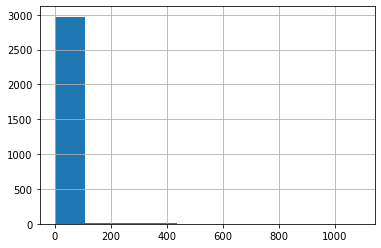

In [60]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count